Автор: Лейман М.А.  
Дата создания: 30.03.2025  

# ARIMA / SARIMA алгоритмы для сезонных timescale данных

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt  
import pathlib 
import pandas as pd
import numpy as np
from glob import glob
import os 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as ticker
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error



print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls dataset

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/14_ARIMA_SARIMA

Датасет: 
aus-employment.csv		milk-production.csv
daily-minimum-temperatures.csv	monthly-beer-production-in-austr.csv
dataset.csv			sales-of-shampoo.csv


In [44]:

def adfuller_def(df):

    result = adfuller(df.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    if result[1] < 0.05:
        print("Ряд стационарен (отвергаем H0)")
    else:
        print("Ряд нестационарен (не отвергаем H0), нужно брать разности.")
    print(result)



def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC') # тест предполагает линейный тренд

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")


def analiz_data(data):
    ''' 
        Анализ данных
    '''
    # Выбираем только числовые столбцы
    numeric_columns = data.select_dtypes(include=[np.number])
    eda_results = pd.DataFrame({
    "Доля пропусков (%)": numeric_columns.isnull().mean() * 100,
    "Максимальное значение": numeric_columns.max(),
    "Минимальное значение": numeric_columns.min(),
    "Среднее значение": numeric_columns.mean(),
    "Медиана": numeric_columns.median(),
    "Дисперсия": numeric_columns.var(),
    "Квантиль 0.1": numeric_columns.quantile(0.1),
    "Квантиль 0.9": numeric_columns.quantile(0.9),
    "Квартиль 1 (25%)": numeric_columns.quantile(0.25),
    "Квартиль 3 (75%)": numeric_columns.quantile(0.75)
    })

    # Выбираем только категориальные столбцы
    categorical_columns = data.select_dtypes(exclude=[np.number])
    # Рассчитываем статистики
    eda_categorical = pd.DataFrame({
        "Доля пропусков (%)": categorical_columns.isnull().mean() * 100,
        "Количество уникальных значений": categorical_columns.nunique(),
        "Наиболее частое значение (мода)": categorical_columns.mode().iloc[0],
        "Частота моды (%)": categorical_columns.apply(lambda x: x.value_counts(normalize=True).iloc[0] * 100)
    })

    # Выводим результаты
    print("Числовые признаки: \n")
    print(eda_results.to_string())
    print("\nКатегориальные признаки: \n")
    print(eda_categorical.to_string())
    
    return numeric_columns, categorical_columns




def plot_box_plot(data):
    ''' 
        Построение графиков (ящик с усами)
    '''
    features = data.columns

    num_features = len(features)

    fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

    for i, feature in enumerate(features):
        sns.boxplot(y=data[feature], ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()



def plot_histogram(data):
    ''' 
        Построение гарфиков  гистограм
    '''
    features = data.columns

    num_features = len(features)
    num_rows = (num_features + 1) // 2  

    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
    axes = axes.flatten() 

    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Распределение признака "{feature}"')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## 1) Загрузка данных

In [ ]:
train_df = pd.read_csv('dataset/dataset.csv')

print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

print("\nПропуски:")
train_df.isnull().sum()


Размер данных:  (397, 2)
    DATE  IPG2211A2N
1/1/1985     72.5052
2/1/1985     70.6720
3/1/1985     62.4502
4/1/1985     57.4714
5/1/1985     55.3151

Пропуски:


DATE          0
IPG2211A2N    0
dtype: int64

## 2) Проверка даты

In [ ]:
# Преобразуем колонку DATE в формат datetime и установим ее как индекс
train_df['DATE'] = pd.to_datetime(train_df['DATE'])
train_df.set_index('DATE', inplace=True)

# Проверим результат
print(train_df.head())
print(train_df.index)


            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)


## 3) Анализ  EDA

In [5]:
print(train_df.info())

print(train_df.describe())
print(train_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB
None
       IPG2211A2N
count  397.000000
mean    88.847218
std     15.387834
min     55.315100
25%     77.105200
50%     89.779500
75%    100.524400
max    129.404800
IPG2211A2N    0
dtype: int64


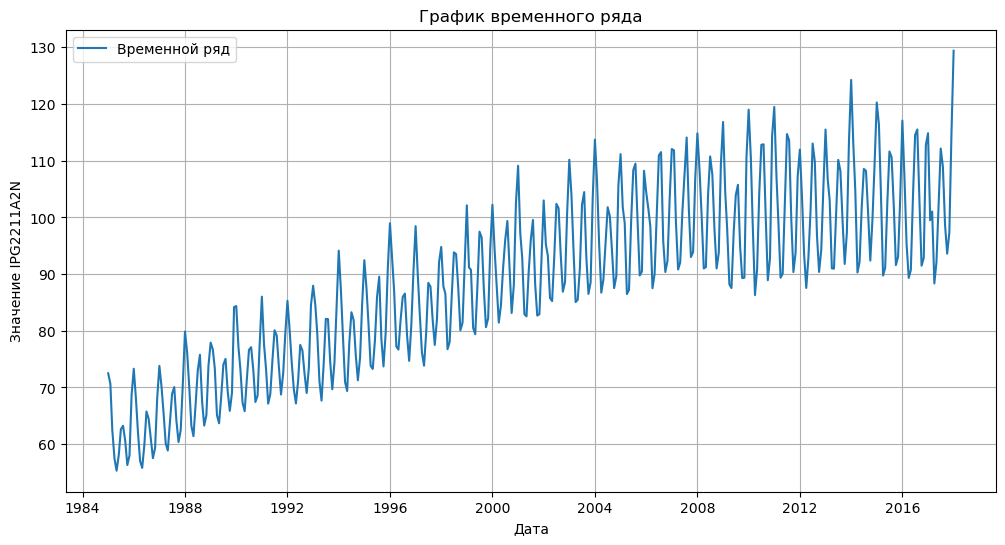

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_df, label="Временной ряд")
plt.xlabel("Дата")
plt.ylabel("Значение IPG2211A2N")
plt.title("График временного ряда")
plt.legend()
plt.grid()
plt.show()


In [7]:
train_df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPG2211A2N,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048


# 4) Анализ временного ряда

In [45]:
adfuller_def(train_df['IPG2211A2N'])

ADF Statistic: -2.2569903500472406
p-value: 0.18621469116586908
Ряд нестационарен (не отвергаем H0), нужно брать разности.
(-2.2569903500472406, 0.18621469116586908, 15, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.8474501627156)


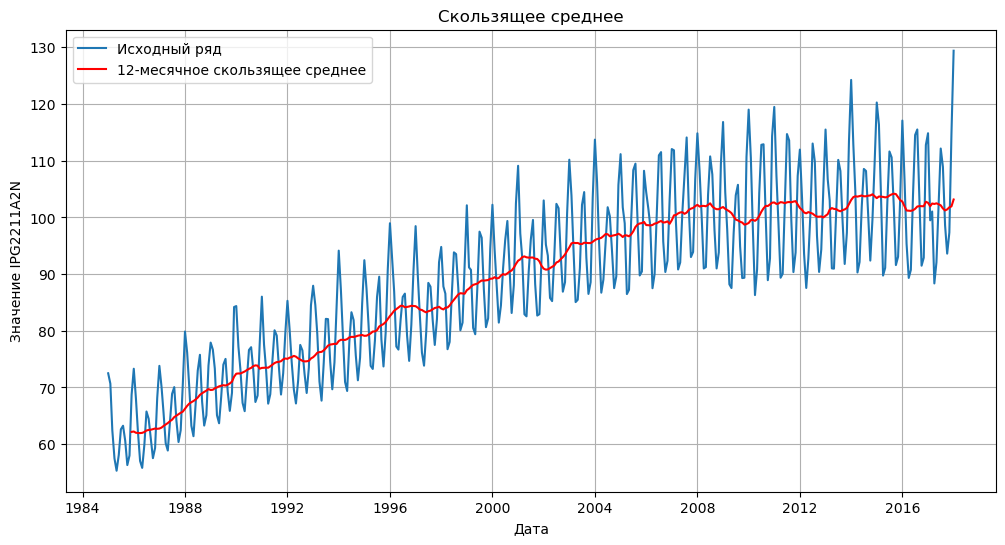

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train_df, label="Исходный ряд")

# 12-месячное скользящее среднее
train_df['rolling_mean'] = train_df['IPG2211A2N'].rolling(window=12).mean()
plt.plot(train_df['rolling_mean'], label="12-месячное скользящее среднее", color='red')

plt.xlabel("Дата")
plt.ylabel("Значение IPG2211A2N")
plt.title("Скользящее среднее")
plt.legend()
plt.grid()
plt.show()


### Есть восходящий тренд

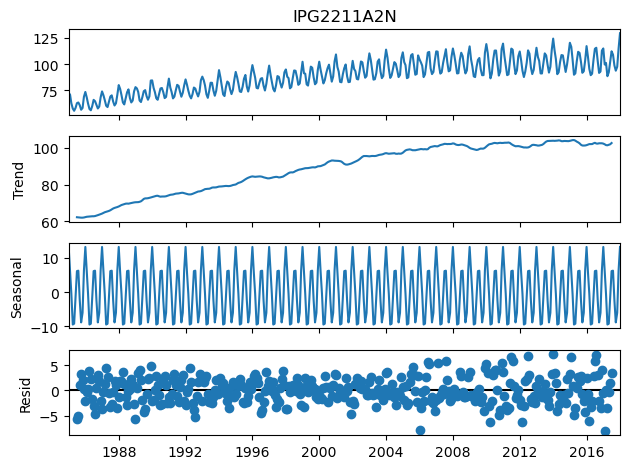

In [ ]:
decomposition = seasonal_decompose(train_df['IPG2211A2N'], model='additive', period=12)
decomposition.plot()
plt.show()


### Есть сезонность

## 5) Стационарность

In [46]:
adfuller_def(train_df['IPG2211A2N'])

ADF Statistic: -2.2569903500472406
p-value: 0.18621469116586908
Ряд нестационарен (не отвергаем H0), нужно брать разности.
(-2.2569903500472406, 0.18621469116586908, 15, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.8474501627156)


In [47]:
train_df['diff'] = train_df['IPG2211A2N'].diff()

In [51]:
adfuller_def(train_df['diff'])

ADF Statistic: -7.104890882267309
p-value: 4.0777865655394705e-10
Ряд стационарен (отвергаем H0)
(-7.104890882267309, 4.0777865655394705e-10, 14, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.5415092614144)


### p-value: 4.0777865655394705e-10 < 0.05 

Значит: d = 1

## 6) Разделение данных

In [ ]:

train_size = int(len(train_df) * 0.9)  
test_size = len(train_df) - train_size  

train = train_df.iloc[:train_size] 
test = train_df.iloc[train_size:]  

print(f'Размер тренеровочной выборки: {len(train)}')
print(f'Размер тестовой выборки: {len(test)}')

Размер тренеровочной выборки: 357
Размер тестовой выборки: 40


## 7) Подбор параметров

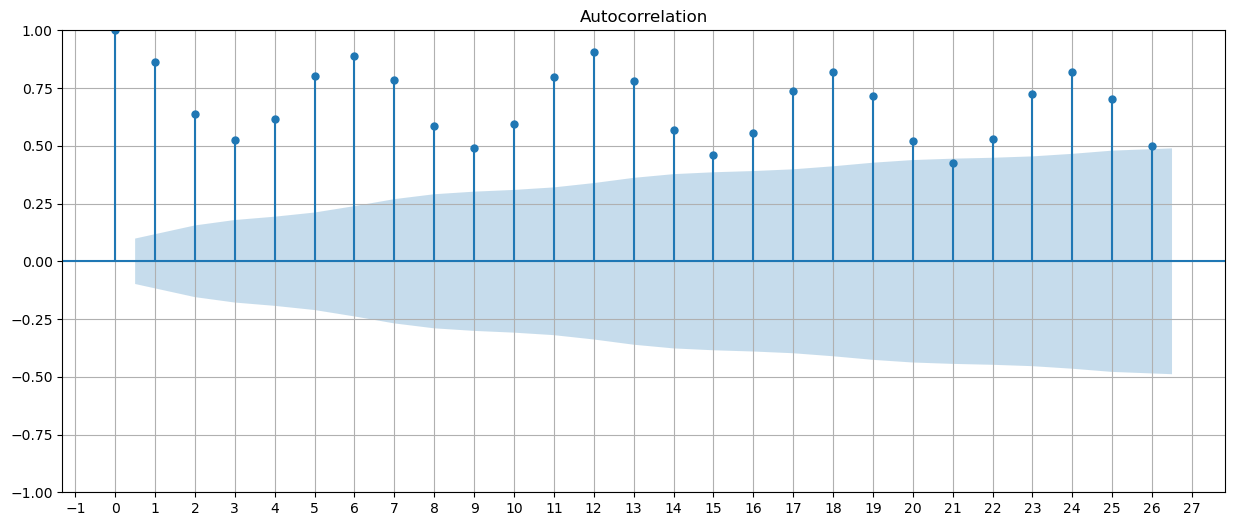

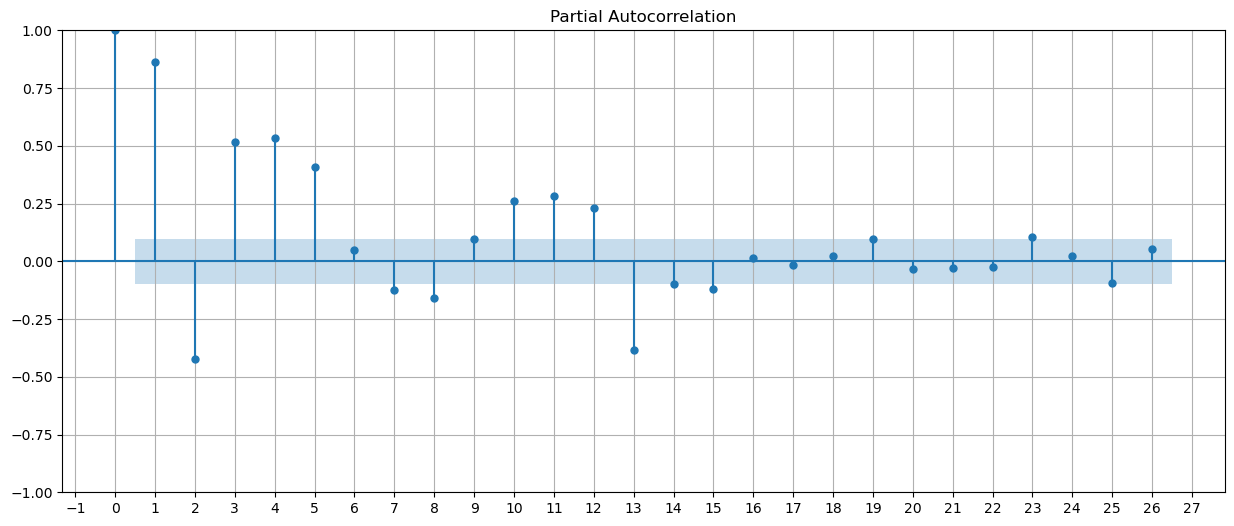

In [ ]:

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(train_df['IPG2211A2N'],  ax=ax)
ax.grid(True)  # Включаем сетку
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(train_df['IPG2211A2N'],  ax=ax)
ax.grid(True)  
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  
plt.show()

In [ ]:
model = auto_arima(train_df['IPG2211A2N'],  
                   d=1,  
                   seasonal=False,  
                   trace=True,  
                   suppress_warnings=True,  
                   stepwise=True)  

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2105.109, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2493.118, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2235.015, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2449.570, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2219.925, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2102.796, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2504.0

In [ ]:
model = auto_arima(train_df['IPG2211A2N'],  
                   d=1,  
                   seasonal=True,  
                   trace=True,  
                   suppress_warnings=True,  
                   stepwise=True)  

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2105.109, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2493.118, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2235.015, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2449.570, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2219.925, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2102.796, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2504.0

## 8) Обучение Arima

In [ ]:
model = ARIMA(train['IPG2211A2N'], order=(4, 1, 2))
arima_result = model.fit()

forecast = arima_result.forecast(steps=test_size)

print(forecast)


/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2014-10-01     90.946433
2014-11-01     94.355957
2014-12-01    106.506695
2015-01-01    114.125288
2015-02-01    110.024954
2015-03-01     98.496331
2015-04-01     90.948698
2015-05-01     94.928586
2015-06-01    106.470234
2015-07-01    113.995797
2015-08-01    109.967564
2015-09-01     98.441413
2015-10-01     90.972899
2015-11-01     95.033815
2015-12-01    106.539331
2016-01-01    113.955905
2016-02-01    109.862579
2016-03-01     98.376591
2016-04-01     91.012153
2016-05-01     95.137893
2016-06-01    106.604082
2016-07-01    113.916449
2016-08-01    109.758572
2016-09-01     98.312320
2016-10-01     91.051919
2016-11-01     95.241702
2016-12-01    106.667877
2017-01-01    113.876407
2017-02-01    109.654954
2017-03-01     98.248995
2017-04-01     91.092239
2017-05-01     95.345127
2017-06-01    106.730733
2017-07-01    113.835810
2017-08-01    109.551722
2017-09-01     98.186606
2017-10-01     91.133109
2017-11-01     95.448164
2017-12-01    106.792654
2018-01-01    113.794669


/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


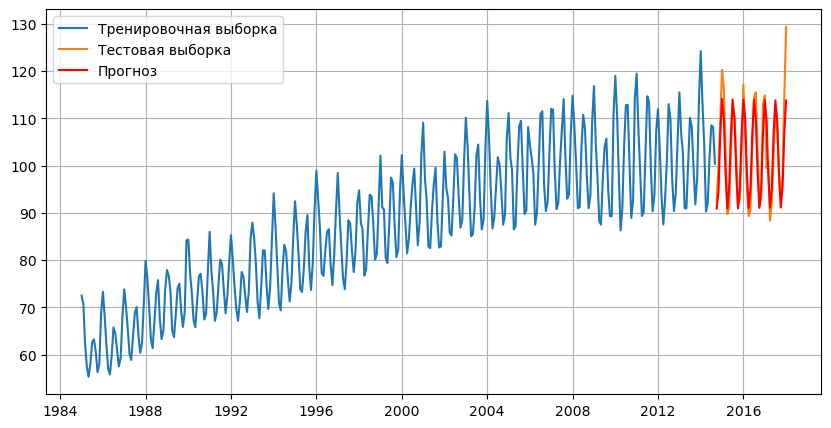

In [ ]:

plt.figure(figsize=(10, 5))


plt.plot(train.index, train['IPG2211A2N'], label="Тренировочная выборка")

plt.plot(test.index, test['IPG2211A2N'], label="Тестовая выборка")

plt.plot(test.index, forecast, label="Прогноз", color='red')

plt.legend()
plt.grid(True)
plt.show()


## 9) модель  SARIMA

In [ ]:
p, d, q = 4, 1, 2  
P, D, Q, m = 1, 1, 1, 12  

sarima_model = SARIMAX(train['IPG2211A2N'],
                      order=(p, d, q),
                      seasonal_order=(P, D, Q, m),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

sarima_result = sarima_model.fit()

print(sarima_result.summary())


/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  357
Model:             SARIMAX(4, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -734.738
Date:                              Sun, 30 Mar 2025   AIC                           1487.475
Time:                                      14:12:18   BIC                           1521.612
Sample:                                  01-01-1985   HQIC                          1501.095
                                       - 09-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5298      0.827      0.640      0.522      -1.091       2.151
ar.L2         -0.09

/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:

forecast_sarima = sarima_result.forecast(steps=test_size)

print(forecast_sarima)


2014-10-01     92.816815
2014-11-01     96.224520
2014-12-01    111.603570
2015-01-01    119.550213
2015-02-01    109.985989
2015-03-01    102.345365
2015-04-01     91.299993
2015-05-01     93.052797
2015-06-01    103.233462
2015-07-01    112.058769
2015-08-01    111.253641
2015-09-01    100.768632
2015-10-01     93.135275
2015-11-01     96.639654
2015-12-01    111.933202
2016-01-01    120.016688
2016-02-01    110.542011
2016-03-01    102.923018
2016-04-01     91.895322
2016-05-01     93.651158
2016-06-01    103.826708
2016-07-01    112.648671
2016-08-01    111.841134
2016-09-01    101.354521
2016-10-01     93.720766
2016-11-01     97.225179
2016-12-01    112.518855
2017-01-01    120.602494
2017-02-01    111.127917
2017-03-01    103.508967
2017-04-01     92.481285
2017-05-01     94.237119
2017-06-01    104.412663
2017-07-01    113.234620
2017-08-01    112.427081
2017-09-01    101.940466
2017-10-01     94.306710
2017-11-01     97.811124
2017-12-01    113.104799
2018-01-01    121.188439


In [ ]:
mse_sarima = mean_squared_error(test['IPG2211A2N'], forecast)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test['IPG2211A2N'], forecast)

print(f'MSE: {mse_sarima}')
print(f'RMSE: {rmse_sarima}')
print(f'MAE: {mae_sarima}')


MSE: 21.04249546724729
RMSE: 4.587209987263204
MAE: 3.5550316861970708


In [ ]:
mse_sarima = mean_squared_error(test['IPG2211A2N'], forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test['IPG2211A2N'], forecast_sarima)

print(f'MSE: {mse_sarima}')
print(f'RMSE: {rmse_sarima}')
print(f'MAE: {mae_sarima}')


MSE: 14.963228683900883
RMSE: 3.8682332768204253
MAE: 2.9184679904518673


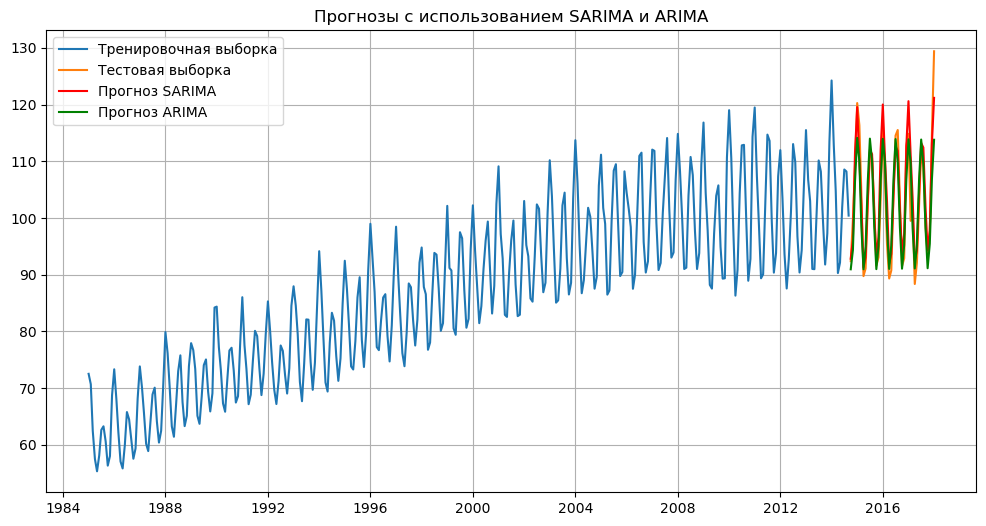

In [ ]:
# графики  ARIMA и SARIMA
plt.figure(figsize=(12, 6))

# Исторические данные
plt.plot(train.index, train['IPG2211A2N'], label="Тренировочная выборка")

# Тестовые данные
plt.plot(test.index, test['IPG2211A2N'], label="Тестовая выборка")

# Прогноз SARIMA
plt.plot(test.index, forecast_sarima, label="Прогноз SARIMA", color='red')
plt.plot(test.index, forecast, label="Прогноз ARIMA", color='green')

plt.legend()
plt.grid(True)
plt.title("Прогнозы с использованием SARIMA и ARIMA")
plt.show()


## Выводы
SARIMA  показала результат лучше.  

SARIMA более точна в плане средних ошибок (MAE) и среднеквадратичных ошибок (RMSE), что предполагает, что она даёт более стабильные прогнозы в большинстве случаев.  
